In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from train_functions import *
from feature_functions import *
import os
import seaborn as sns
import warnings
from sklearn.metrics import r2_score
import random
from feature_functions import load_pickle

# Generate data

In [3]:
data = pd.read_csv('../data/kcat_merge.csv')
case_data = pd.read_csv('../data/case_studies/PFOCT_case.csv')

In [5]:
seq = get_seq_func('Q51742')

In [17]:
wt_seq = get_seq_func('Q51742')
seq_list = []
for i in range(len(case_data.index)):
    if list(case_data['Mutation'])[i] == 'None':
        seq_list.append(wt_seq)
    else:
        mut_list= list(case_data['Mutation'])[i].split('/')
        mut_seq = wt_seq
        for mut in mut_list:
            ind = int(mut[1:-1])
            new = mut[-1].upper()
            temp_list = list(mut_seq)
            temp_list[ind] = new
            mut_seq = ''.join(temp_list)
        seq_list.append(mut_seq)
case_data['seq'] = seq_list

In [20]:
Temp_K = [ float(T+273.15) for T in list(case_data['Temp']) ]
Inv_Temp =  [ 1/float(T+273.15) for T in list(case_data['Temp']) ]
T_K_norm = scale_minmax( Temp_K, min(data['Temp_K']) , max(data['Temp_K']))
inv_T_norm = scale_minmax( Inv_Temp, min(data['Inv_Temp']) , max(data['Inv_Temp']))
case_data['Temp_K_norm'] = T_K_norm
case_data['Inv_Temp_norm'] = inv_T_norm

In [22]:
case_data.to_csv('../data/case_studies/PFOCT_case.csv',index=None)

# Result

In [2]:
result = pd.read_csv('../data/case_studies/predPFOCT.csv')
result['Target'] = np.log10(result['kcat'])

In [4]:
def get_rmse(x,y):
    rmse = sqrt(((x - y)**2).mean(axis=0))
    return round(rmse, 4)
def get_r2(x,y):
    return round( r2_score(x,y), 4)
from scipy.stats import gaussian_kde
def scatter_with_gaussian_kde(ax, x, y, size):
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    ax.scatter(x, y, c=z, s=size)

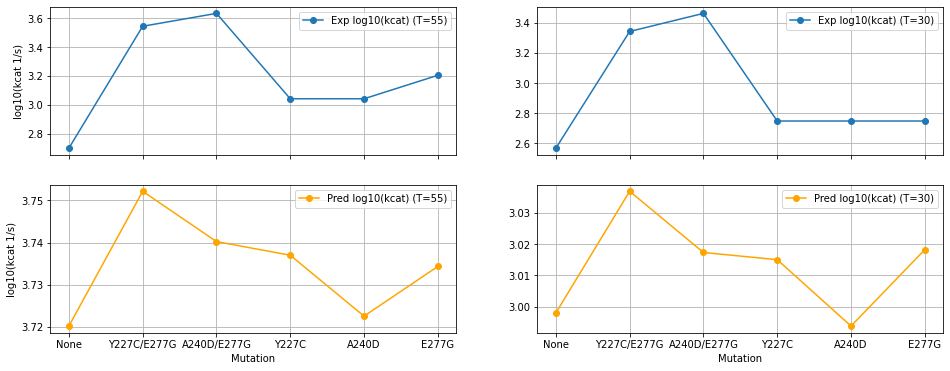

In [6]:
fig, axs = plt.subplots(2,2,figsize=(16,6), sharex=True)
axs[0][0].plot(list(result['Mutation'])[:6], list(result['Target'])[:6],marker='o',label='Exp log10(kcat) (T=55)')
axs[0][1].plot(list(result['Mutation'])[6:], list(result['Target'])[6:],marker='o',label='Exp log10(kcat) (T=30)')
axs[1][0].plot(list(result['Mutation'])[:6], list(result['pred_log10kcat'])[:6],color='orange',marker='o',
               label='Pred log10(kcat) (T=55)')
axs[1][1].plot(list(result['Mutation'])[6:], list(result['pred_log10kcat'])[6:],color='orange',marker='o',
               label='Pred log10(kcat) (T=30)')
for i in range(2):
    for j in range(2):
        axs[i][j].legend()
        axs[i][j].grid()
        if i == 1:
            axs[i][j].set_xlabel('Mutation')
        if j == 0:
            axs[i][j].set_ylabel('log10(kcat 1/s)')

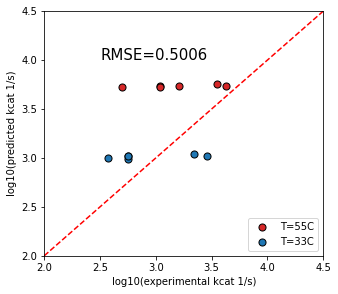

In [28]:
result_55, result_33 = result[result['Temp']==55].reset_index(), result[result['Temp']==30].reset_index()
fig, ax = plt.subplots(1,1,figsize=(5,4.5))
ax.scatter(result_55['Target'] , result_55['pred_log10kcat'], s= 50,
           edgecolor='black',linewidth=1, color='tab:red',label='T=55C')
ax.scatter(result_33['Target'] , result_33['pred_log10kcat'], s= 50,
           edgecolor='black',linewidth=1, color='tab:blue',label='T=33C')
ax.set_xlim([2,4.5])
ax.set_ylim([2,4.5])
ax.set_xlabel('log10(experimental kcat 1/s)')
ax.set_ylabel('log10(predicted kcat 1/s)')
ax.plot([2,4.5],[2,4.5],'r--')
ax.text(x=2.5,y=4.0,s='RMSE='+str( get_rmse(result['Target'] , result['pred_log10kcat']) ), fontsize=15)
ax.legend(loc='lower right')